In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from tqdm import tqdm
from scipy.stats import uniform, randint
import time
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None


class RandomForestClassifier_GA_Optimizer():
    def __init__(self):
        self.output_score = []

    def best_estimator(self, X_train, X_test, y_train, y_test, rf_parameters, error_metric, population_size,
                       number_of_generation, mutation_rate, random_state=42):
        '''
        X_train, X_test, y_train, y_test : X, y의 train, test data (**DataFrame)
        rf_parameters : 모델에 최적화할 파라미터 (범위) 입력
        rf_parameters = {'n_estimators': [2,3,4,.....1000],
            'max_features': ['sqrt', 'auto', 'log2', None],
            'min_samples_leaf': [2,3,4,5,6,.....16],
            'max_depth': [2,3,4,5,6,.....20],
            'criterion': ['gini', 'entropy'],
            'oob_score': [True, False]
            }
        error_metric : 평가 지표
        population_size : 초기해 크기
        number_of_generation : 최대 세대수
        mutation_rate : 돌연변이율
        random_state : 랜덤 고정 상수
        '''

        # --------------------------------------------   Model function   --------------------------------------------
        ## i라는 row에 대한 평가값을 계산하는 목적 함수
        objective_function = lambda i: self.objective(error_metric, i, X_train, X_test, y_train, y_test,
                                                      random_state)
        # ------------------------------------------------------------------------------------------------------------

        # --------------------------------------------   초기해 생성   --------------------------------------------
        population = pd.DataFrame()  # parameter들로만 DataFrame 생성
        np.random.seed(random_state)
        population['n_estimators'] = rf_parameters[0].rvs(size=population_size)
        population['criterion'] = np.random.choice(rf_parameters[1], size=population_size)
        population['max_depth'] = rf_parameters[2].rvs(size=population_size)
        population['min_samples_split'] = rf_parameters[3].rvs(size=population_size)
        population['min_samples_leaf'] = rf_parameters[4].rvs(size=population_size)
        population['min_weight_fraction_leaf'] = rf_parameters[5].rvs(size=population_size)
        population['max_features'] = np.random.choice(rf_parameters[6], size=population_size)
        population['max_leaf_nodes'] = rf_parameters[7].rvs(size=population_size)
        population['min_impurity_decrease'] = rf_parameters[8].rvs(size=population_size)
        population['bootstrap'] = np.random.choice(rf_parameters[9], size=population_size)

        population['score'] = population.apply(objective_function, axis=1)

        self.output_score = []
        # --------------------------------------------   iteration   --------------------------------------------
        for g in tqdm(range(number_of_generation), desc="Optimizing Generations"):
            # 부모 쌍 생성
            pairs = self.selection(population, random_state)

            # 교배로 자손 생성
            children = self.crossover(pairs, random_state)
            if 'score' in children.columns:
                children.drop('score', axis=1, inplace=True)

            # 돌연변이 시행
            mutants = self.mutate(children, mutation_rate, rf_parameters, random_state)

            # 자손과 돌연변이를 population에 추가 후 자손의 열을 기준으로 중복되는 값 제거하여 population Update
            population = pd.concat([population, children, mutants], ignore_index=True, sort=False).drop_duplicates(
                subset=children.columns)

            # 새롭게 추가된 population에 대해서 평가
            # population.loc[:, error_metric] = population.apply(objective_function, axis=1)
            population.loc[population['score'].isna(), 'score'] = population[population['score'].isna()].apply(
                objective_function, axis=1)

            # population을 score 기준으로 내림차순 정렬
            population = population.sort_values(by=['score'], ascending=False).iloc[:population_size]

            # 가장 좋은 parameter 세트 선택
            output_params = population.iloc[0]
            # output_params[error_metric] = round(output_params['score'], 2)

            self.output_score.append(output_params['score'])
            output_params.drop('score', inplace=True)

        return [self.get_model(population.loc[population['score'].idxmax()]), output_params]

    # 룰렛 휠 선택
    def selection(self, population, random_state):
        '''
        population : 전체 population
        random_state : 랜덤 고정 상수

        ** 높은 score를 가지는 parameter set가 높은 확률로 선택될 수 있도록 Roulette Wheel Selection **
        '''
        # 랜덤 시드 고정
        np.random.seed(random_state)
        # population 개수 저장
        length = population.shape[0]
        # 각 행의 score의 확률 계산
        prob = population['score'] / population['score'].sum()
        # 각 행의 score 확률에 기반해 랜덤 index 선택(size 개수만큼 선택)
        indices = np.random.choice(np.arange(length), p=prob, size=length)

        return population.iloc[indices]

    # 교배
    def crossover(self, pairs, random_state):
        '''
        pairs : roughlette_wheel_selection으로 선택된 population 쌍
        random_state : 랜덤 고정 상수

        ** 전체 popuation을 기준으로 무작위 교차 **
        '''
        # 랜덤 시드 고정
        np.random.seed(random_state)
        # pairs의 행, 열 개수 저장
        length, width = pairs.shape
        # 열 개수 -1  --> 마지막 열 = 'score'이므로 score는 제외하고 교배
        width -= 1

        # 교배율X --> (0, 1)을 각 parameter마다 랜덤 생성하여 새로운 배열의 자손 생성
        ## 0, 1을 전체 parameter 수 만큼 랜덤 생성
        a = np.random.choice((0, 1), size=length * width)
        ## 교배(교차)를 시키기 위한 단계(짝수번 째에 -1을 곱함)
        a[np.arange(1, length * width, 2)] *= -1
        ## 새로운 배열을 생성할 인덱스 'i' 리스트 생성
        i = np.arange(length * width) + a

        # i 리스트를 이용하여 새로운 자손 생성
        ## score열을 제외하고 DataFrame을 flatten 시켜 1차원 배열로 생성
        gene_list = np.array(pairs.drop('score', axis=1)).reshape(-1, order='F')
        ## 1차원 배열로 생성된 parameter 값들에 i 리스트에 해당하는 값들로 새롭게 자손 parameter 세트 생성
        return pd.DataFrame(gene_list[i].reshape((-1, width), order='F'), columns=pairs.columns[:-1])

    # 돌연변이
    def mutate(self, population, mutation_rate, rf_parameters, random_state):
        '''
        population : 전체 population
        mutation_rate : 돌연변이율
        rf_parameters : hyper-parameter 리스트
        random_state : 랜덤 고정 상수

        ** 돌연변이율에 따라 population 돌연변이 **
        Mutate the population with a given mutation rate.
        '''
        # children의 행, 열 개수 저장
        length, width = population.shape
        # 랜덤 시드 고정
        np.random.seed(random_state)

        # 전체 파라미터를 1차원 배열로 flatten
        pop_array = np.array(population).reshape(-1, order='F')

        # 돌연변이가 발생할 인덱스 리스트 생성
        change_indices = np.random.choice(
            np.arange(length * width),
            size=int(mutation_rate * length * width),
            replace=False)

        # 돌연변이가 발생할 새 데이터 리스트 생성
        change_indices.sort()
        new_values = []

        for i in range(width):
            # change_indices에서 i번째 열에 해당하는 인덱스 범위 추출
            indices_in_column = change_indices[(i * length <= change_indices) & (change_indices < (i + 1) * length)]
            # 해당 인덱스 수 만큼 랜덤 값을 선택하여 new_values에 추가
            if i == 1 or i == 6 or i == 9:
                new_values.extend(np.random.choice(rf_parameters[i], size=len(indices_in_column)))
            else:
                new_values.extend(rf_parameters[i].rvs(size=len(indices_in_column)))


        # 돌연변이가 발생할 랜덤 인덱스에 새 데이터로 업데이트(돌연변이)
        pop_array[change_indices] = new_values
        # mutants(return)는 자손에서 돌연변이 시킨 parameter DataFrame
        mutants = pd.DataFrame(pop_array.reshape((-1, width), order='F'))
        mutants.columns = population.columns

        return mutants

    # 모델 return
    def get_model(self, row, random_state=42):
        '''
        row : 평가값이 가장 좋은 population의 row
        random_state : 랜덤 고정 상수

        ** best hyper-parameter를 갖는 모델을 return **
        '''

        return RandomForestClassifier(
            n_estimators=int(row[0]),
            criterion=row[1],
            max_depth=int(row[2]),
            min_samples_split=int(row[3]),
            min_samples_leaf=int(row[4]),
            min_weight_fraction_leaf=row[5],
            max_features=row[6],
            max_leaf_nodes=int(row[7]),
            min_impurity_decrease=row[8],
            bootstrap=row[9],
            random_state=random_state,
            n_jobs=-1)

    # 평가값 계산
    def evaluation(self, model, error_metric, X_train, X_test, y_train, y_test):
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        if error_metric == 'accuracy_score':
            eval = accuracy_score(y_test, y_pred_proba)
        elif error_metric == 'f1_score':
            eval = f1_score(y_test, y_pred_proba, average='micro')
        elif error_metric == 'roc_auc_score':
            eval = roc_auc_score(y_test, y_pred_proba, average='macro')

        return eval

    # objective function에 적용되는 평가값 계산하여 반환
    def objective(self, error_metric, row, X_train, X_test, y_train, y_test, random_state):
        '''
        ** score를 계산 **
        '''

        if 'score' in row and row['score'] == row['score']:
            return row['score']

        return self.evaluation(self.get_model(row, random_state=random_state), error_metric,
                               X_train, X_test, y_train, y_test)

    def get_output_score(self):
        return self.output_score

In [ ]:
def Optimize_RFC_HP(X_train, X_test, y_train, y_test, params = {}, error_metric = 'roc_auc_score', population_size = 50,
                 number_of_generation = 10, mutation_rate = 0.05, random_state = 42):
    try:
        rf_parameters = []

        if 'n_estimators' in params.keys():
            rf_parameters.append(params['n_estimators'])
        else:
            rf_parameters.append(np.arange(1, 1000))

        if 'criterion' in params.keys():
            rf_parameters.append(params['criterion'])
        else:
            rf_parameters.append(['gini', 'entropy'])

        if 'max_depth' in params.keys():
            rf_parameters.append(params['max_depth'])
        else:
            rf_parameters.append(np.arange(2, 20))

        # min_samples_split 구현
        if 'min_samples_split' in params.keys():
            rf_parameters.append(params['min_samples_split'])
        else:
            rf_parameters.append(2)

        if 'min_samples_leaf' in params.keys():
            rf_parameters.append(params['min_samples_leaf'])
        else:
            rf_parameters.append(np.arange(1, 20))

        # min_weight_fraction_leaf 구현
        if 'min_weight_fraction_leaf' in params.keys():
            rf_parameters.append(params['min_weight_fraction_leaf'])
        else:
            rf_parameters.append(np.arange(0.0, 0.5, 0.02))

        if 'max_features' in params.keys():
            rf_parameters.append(params['max_features'])
        else:
            rf_parameters.append(['sqrt', 'auto', 'log2', None])

        # max_leaf_nodes 구현
        if 'max_leaf_nodes' in params.keys():
            rf_parameters.append(params['max_leaf_nodes'])
        else:
            rf_parameters.append(None)

        # min_impurity_decrease 구현
        if 'min_impurity_decrease' in params.keys():
            rf_parameters.append(params['min_impurity_decrease'])
        else:
            rf_parameters.append(np.arange(0.0, 1.0, 0.05))

        # bootstrap 구현
        if 'bootstrap' in params.keys():
            rf_parameters.append(params['bootstrap'])
        else:
            rf_parameters.append([True, False])

        optimizer = RandomForestClassifier_GA_Optimizer()
        model, row = optimizer.best_estimator(X_train, X_test, y_train, y_test, rf_parameters, error_metric,
                                        population_size, number_of_generation, mutation_rate, random_state)

        output_score = optimizer.get_output_score()
        plt.plot(range(len(output_score)), output_score)
        plt.xlabel('Generation')
        plt.ylabel('Score')
        plt.title('Score Over Generation')
        plt.grid(True)
        plt.show()

        return model, row
    except Exception as e:
        print("Exception parameter error:",e)
        return None, None

### 초기해 = 150, 최대 세대수 = 100, 돌연변이율 = 0.1

Optimizing Generations: 100%|██████████| 100/100 [2:00:32<00:00, 72.32s/it]


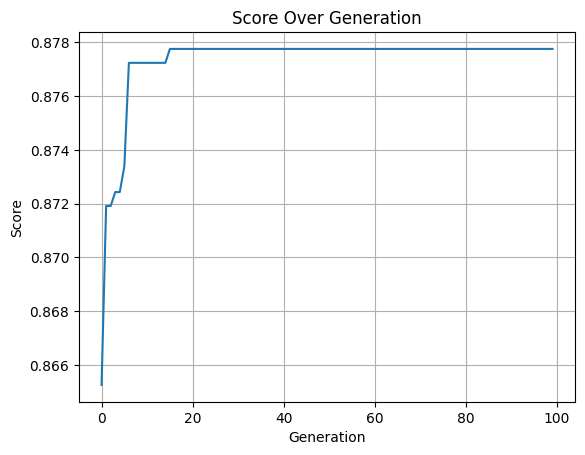

n_estimators                     225
criterion                    entropy
max_depth                         59
min_samples_split                 97
min_samples_leaf                  88
min_weight_fraction_leaf    0.006836
max_features                    None
max_leaf_nodes                    16
min_impurity_decrease       0.013094
bootstrap                       True
Name: 0, dtype: object
7315.960129499435


In [ ]:
from scipy.stats import uniform, randint

start_time = time.time()

train = pd.read_csv('dataset/train.csv')

X = train.drop(['person_id', 'login'], axis=1)
y = train['login']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle = True, stratify = y, random_state=42)

# params= {
#     'n_estimators': [10, 50, 100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000],
#     'criterion': ['gini','entropy'],
#     'max_depth': [None, 1,5,10,15,20,25,30,35,40,45,50],
#     'min_samples_split' : [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],
#     'min_samples_leaf': [1, 5,10,15,20,25,30,35,40,45,50],
#     'min_weight_fraction_leaf': [0.0, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
#     'max_features':['sqrt','log2',None],
#     'max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90,100],
#     'min_impurity_decrease':[0.0, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
#     'bootstrap': [True,False]
# }

params= {
    'n_estimators': randint(10, 1000),
    'criterion': ['gini','entropy'],
    'max_depth': randint(1, 100),
    'min_samples_split' : randint(2, 100),
    'min_samples_leaf': randint(1, 100),
    'min_weight_fraction_leaf': uniform(0.0, 0.5),
    'max_features':['sqrt','log2',None],
    'max_leaf_nodes':randint(2, 100),
    'min_impurity_decrease':uniform(0.0, 1.0),
    'bootstrap': [True,False]
}


model, hyp_param = Optimize_RFC_HP(X_train=X_train, y_train=y_train, y_test=y_test, X_test=X_test,
                                 params=params, number_of_generation=100, population_size=150,
                                 error_metric='roc_auc_score', mutation_rate=0.1, random_state = 42)
end_time = time.time()
print(hyp_param)
print(end_time - start_time)

In [18]:
hyp_param = pd.Series({
    'n_estimators': 225,
    'criterion': 'entropy',
    'max_depth': 59,
    'min_samples_split': 97,
    'min_samples_leaf': 88,
    'min_weight_fraction_leaf': 0.006836,
    'max_features': None,
    'max_leaf_nodes': 16,
    'min_impurity_decrease': 0.013094,
    'bootstrap': True
})

# Series를 딕셔너리로 변환
hyp_param_dict = hyp_param.to_dict()

# 찾은 최적의 파라미터들을 제출 양식에 맞게 제출
submit = pd.read_csv('dataset/sample_submission.csv')
for param, value in hyp_param_dict.items():
    if param in submit.columns:
        submit[param] = value
        
# score 평가
params = hyp_param_dict
train = pd.read_csv('dataset/train.csv')

X = train.drop(['person_id', 'login'], axis=1)
y = train['login']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle = True, stratify = y, random_state=42)

model = RandomForestClassifier(random_state=42, **params)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
# predictions = model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba, average='macro')
print(f'valid_score = {auc_score}')

# submission 저장
submit.to_csv(f'dataset/submission/submission_2(150, 100, 0.1)_{round(auc_score,5)}.csv', index=False)
submit

valid_score = 0.8777564007695722


,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,max_leaf_nodes,min_impurity_decrease,bootstrap
0,225,entropy,59,97,88,0.006836,None,16,0.013094,True


### 초기해 = 250, 최대 세대수 = 100, 돌연변이율 = 0.1

Optimizing Generations: 100%|██████████| 100/100 [2:03:26<00:00, 74.06s/it]  


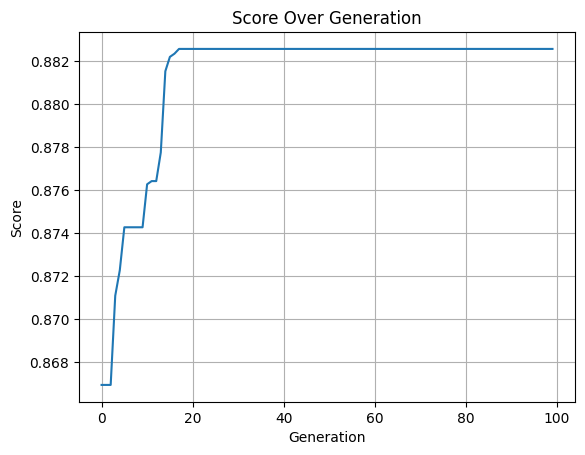

n_estimators                      48
criterion                    entropy
max_depth                         24
min_samples_split                 62
min_samples_leaf                  21
min_weight_fraction_leaf    0.032427
max_features                    None
max_leaf_nodes                    91
min_impurity_decrease        0.00494
bootstrap                       True
Name: 0, dtype: object
7547.167972326279


In [ ]:
from scipy.stats import uniform, randint

start_time = time.time()

train = pd.read_csv('dataset/train.csv')

X = train.drop(['person_id', 'login'], axis=1)
y = train['login']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle = True, stratify = y, random_state=42)

# params= {
#     'n_estimators': [10, 50, 100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000],
#     'critertion': ['gini','entropy'],
#     'max_depth': [None, 1,5,10,15,20,25,30,35,40,45,50],
#     'min_samples_split' : [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],
#     'min_samples_leaf': [1, 5,10,15,20,25,30,35,40,45,50],
#     'min_weight_fraction_leaf': [0.0, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
#     'max_features':['sqrt','log2',None],
#     'max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90,100],
#     'min_impurity_decrease':[0.0, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
#     'bootstrap': [True,False]
# }

params= {
    'n_estimators': randint(10, 1000),
    'critertion': ['gini','entropy'],
    'max_depth': randint(1, 100),
    'min_samples_split' : randint(2, 100),
    'min_samples_leaf': randint(1, 100),
    'min_weight_fraction_leaf': uniform(0.0, 0.5),
    'max_features':['sqrt','log2',None],
    'max_leaf_nodes':randint(2, 100),
    'min_impurity_decrease':uniform(0.0, 1.0),
    'bootstrap': [True,False]
}


model, hyp_param = Optimize_RFC_HP(X_train=X_train, y_train=y_train, y_test=y_test, X_test=X_test,
                                 params=params, number_of_generation=100, population_size=250,
                                 error_metric='roc_auc_score', mutation_rate=0.1, random_state = 42)
end_time = time.time()
print(hyp_param)
print(end_time - start_time)

In [17]:
hyp_param = pd.Series({
    'n_estimators': 48,
    'criterion': 'entropy',
    'max_depth': 24,
    'min_samples_split': 62,
    'min_samples_leaf': 21,
    'min_weight_fraction_leaf': 0.032427,
    'max_features': None,
    'max_leaf_nodes': 91,
    'min_impurity_decrease': 0.00494,
    'bootstrap': True
})

# Series를 딕셔너리로 변환
hyp_param_dict = hyp_param.to_dict()

# 찾은 최적의 파라미터들을 제출 양식에 맞게 제출
submit = pd.read_csv('dataset/sample_submission.csv')
for param, value in hyp_param_dict.items():
    if param in submit.columns:
        submit[param] = value
        
# score 평가
params = hyp_param_dict
train = pd.read_csv('dataset/train.csv')

X = train.drop(['person_id', 'login'], axis=1)
y = train['login']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle = True, stratify = y, random_state=42)

model = RandomForestClassifier(random_state=42, **params)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
# predictions = model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba, average='macro')
print(f'valid_score = {auc_score}')

# submission 저장
submit.to_csv(f'dataset/submission/submission_2(250, 100, 0.1)_{round(auc_score,5)}.csv', index=False)
submit

valid_score = 0.8825662276158058


,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,max_leaf_nodes,min_impurity_decrease,bootstrap
0,48,entropy,24,62,21,0.032427,None,91,0.00494,True


### 초기해 = 50, 최대 세대수 = 100, 돌연변이율 = 0.1

Optimizing Generations: 100%|██████████| 100/100 [41:01<00:00, 24.62s/it] 


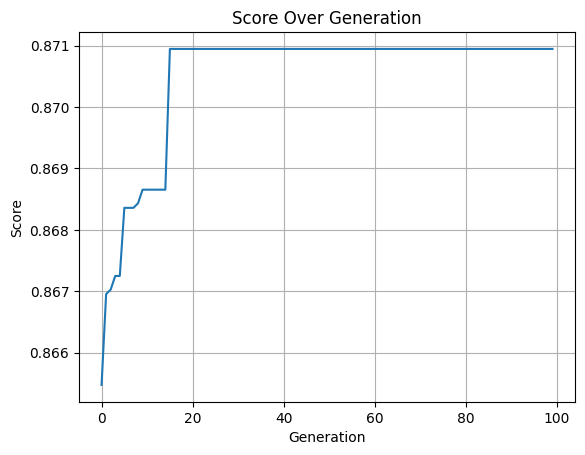

n_estimators                     334
criterion                       gini
max_depth                         24
min_samples_split                 49
min_samples_leaf                  52
min_weight_fraction_leaf    0.087477
max_features                    sqrt
max_leaf_nodes                    45
min_impurity_decrease       0.005185
bootstrap                       True
Name: 0, dtype: object
2487.6176278591156


In [ ]:
from scipy.stats import uniform, randint

start_time = time.time()

train = pd.read_csv('dataset/train.csv')

X = train.drop(['person_id', 'login'], axis=1)
y = train['login']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle = True, stratify = y, random_state=42)

# params= {
#     'n_estimators': [10, 50, 100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000],
#     'critertion': ['gini','entropy'],
#     'max_depth': [None, 1,5,10,15,20,25,30,35,40,45,50],
#     'min_samples_split' : [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],
#     'min_samples_leaf': [1, 5,10,15,20,25,30,35,40,45,50],
#     'min_weight_fraction_leaf': [0.0, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
#     'max_features':['sqrt','log2',None],
#     'max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90,100],
#     'min_impurity_decrease':[0.0, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
#     'bootstrap': [True,False]
# }

params= {
    'n_estimators': randint(10, 1000),
    'critertion': ['gini','entropy'],
    'max_depth': randint(1, 100),
    'min_samples_split' : randint(2, 100),
    'min_samples_leaf': randint(1, 100),
    'min_weight_fraction_leaf': uniform(0.0, 0.5),
    'max_features':['sqrt','log2',None],
    'max_leaf_nodes':randint(2, 100),
    'min_impurity_decrease':uniform(0.0, 1.0),
    'bootstrap': [True,False]
}


model, hyp_param = Optimize_RFC_HP(X_train=X_train, y_train=y_train, y_test=y_test, X_test=X_test,
                                 params=params, number_of_generation=20, population_size=50,
                                 error_metric='roc_auc_score', mutation_rate=0.1, random_state = 42)
end_time = time.time()
print(hyp_param)
print(end_time - start_time)

Optimizing Generations: 100%|██████████| 20/20 [13:50<00:00, 41.51s/it]


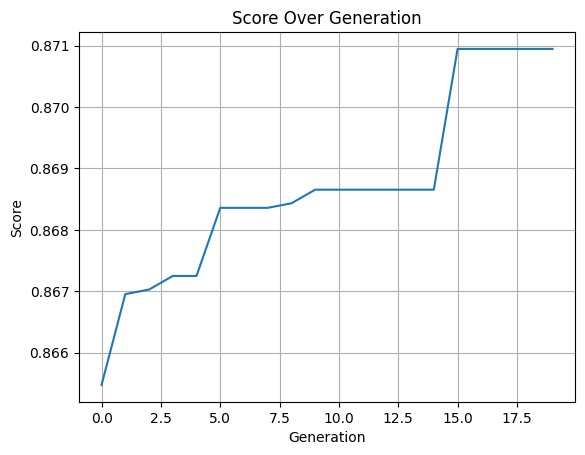

n_estimators                     334
criterion                       gini
max_depth                         24
min_samples_split                 49
min_samples_leaf                  52
min_weight_fraction_leaf    0.087477
max_features                    sqrt
max_leaf_nodes                    45
min_impurity_decrease       0.005185
bootstrap                       True
Name: 0, dtype: object
855.1827538013458


In [ ]:
from scipy.stats import uniform, randint

start_time = time.time()

train = pd.read_csv('dataset/train.csv')

X = train.drop(['person_id', 'login'], axis=1)
y = train['login']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle = True, stratify = y, random_state=42)

# params= {
#     'n_estimators': [10, 50, 100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000],
#     'critertion': ['gini','entropy'],
#     'max_depth': [None, 1,5,10,15,20,25,30,35,40,45,50],
#     'min_samples_split' : [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],
#     'min_samples_leaf': [1, 5,10,15,20,25,30,35,40,45,50],
#     'min_weight_fraction_leaf': [0.0, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
#     'max_features':['sqrt','log2',None],
#     'max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90,100],
#     'min_impurity_decrease':[0.0, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
#     'bootstrap': [True,False]
# }

params= {
    'n_estimators': randint(10, 1000),
    'critertion': ['gini','entropy'],
    'max_depth': randint(1, 100),
    'min_samples_split' : randint(2, 100),
    'min_samples_leaf': randint(1, 100),
    'min_weight_fraction_leaf': uniform(0.0, 0.5),
    'max_features':['sqrt','log2',None],
    'max_leaf_nodes':randint(2, 100),
    'min_impurity_decrease':uniform(0.0, 1.0),
    'bootstrap': [True,False]
}


model, hyp_param = Optimize_RFC_HP(X_train=X_train, y_train=y_train, y_test=y_test, X_test=X_test,
                                 params=params, number_of_generation=20, population_size=50,
                                 error_metric='roc_auc_score', mutation_rate=0.1, random_state = 42)
end_time = time.time()
print(hyp_param)
print(end_time - start_time)

In [19]:
hyp_param = pd.Series({'n_estimators': 334,
 'criterion': 'gini',
 'max_depth': 24,
 'min_samples_split': 49,
 'min_samples_leaf': 52,
 'min_weight_fraction_leaf': 0.08747746354796809,
 'max_features': 'sqrt',
 'max_leaf_nodes': 45,
 'min_impurity_decrease': 0.005184862773986776,
 'bootstrap': True
 })

# Series를 딕셔너리로 변환
hyp_param_dict = hyp_param.to_dict()

# 찾은 최적의 파라미터들을 제출 양식에 맞게 제출
submit = pd.read_csv('dataset/sample_submission.csv')
for param, value in hyp_param_dict.items():
    if param in submit.columns:
        submit[param] = value
        
# score 평가
params = hyp_param_dict
train = pd.read_csv('dataset/train.csv')

X = train.drop(['person_id', 'login'], axis=1)
y = train['login']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle = True, stratify = y, random_state=42)

model = RandomForestClassifier(random_state=42, **params)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
# predictions = model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba, average='macro')
print(f'valid_score = {auc_score}')

# submission 저장
submit.to_csv(f'dataset/submission/submission_2(50, 100, 0.1)_{round(auc_score,5)}.csv', index=False)
submit

valid_score = 0.8709486458487494


,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,max_leaf_nodes,min_impurity_decrease,bootstrap
0,334,gini,24,49,52,0.087477,sqrt,45,0.005185,True


### 초기해 = [350, 400, 450, 500], 최대 세대수 = 25, 돌연변이율 = 0.1 실험

Optimizing Generations: 100%|██████████| 25/25 [2:23:59<00:00, 345.57s/it]  


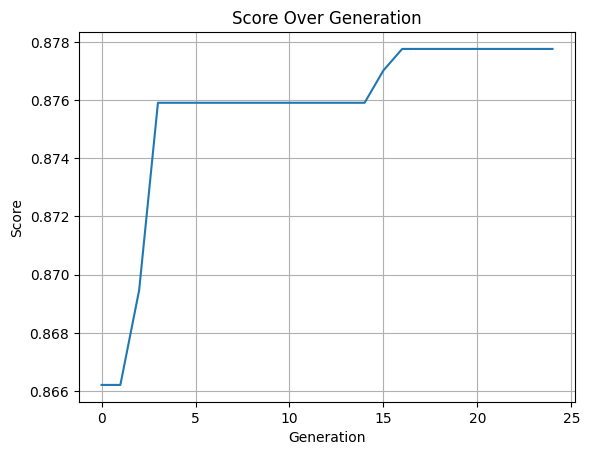

n_estimators                     211
criterion                    entropy
max_depth                         30
min_samples_split                 42
min_samples_leaf                  90
min_weight_fraction_leaf    0.048697
max_features                    None
max_leaf_nodes                    82
min_impurity_decrease       0.012715
bootstrap                       True
Name: 0, dtype: object
초기해 = 350, 최대 세대수 = 25, 돌연변이율 = 0.1의 실행시간: 8847.5485060215
valid_score = 0.8777564007695723
초기해 = 350일 때 완료


Optimizing Generations: 100%|██████████| 25/25 [2:31:14<00:00, 362.97s/it]  


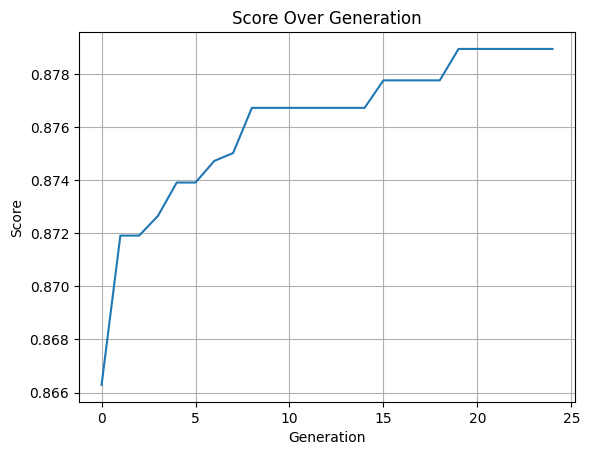

n_estimators                     320
criterion                       gini
max_depth                         94
min_samples_split                 22
min_samples_leaf                  87
min_weight_fraction_leaf    0.105175
max_features                    None
max_leaf_nodes                    14
min_impurity_decrease       0.002104
bootstrap                       True
Name: 0, dtype: object
초기해 = 400, 최대 세대수 = 25, 돌연변이율 = 0.1의 실행시간: 9308.244250059128
valid_score = 0.8789403581471067
초기해 = 400일 때 완료


Optimizing Generations: 100%|██████████| 25/25 [3:51:53<00:00, 556.56s/it]  


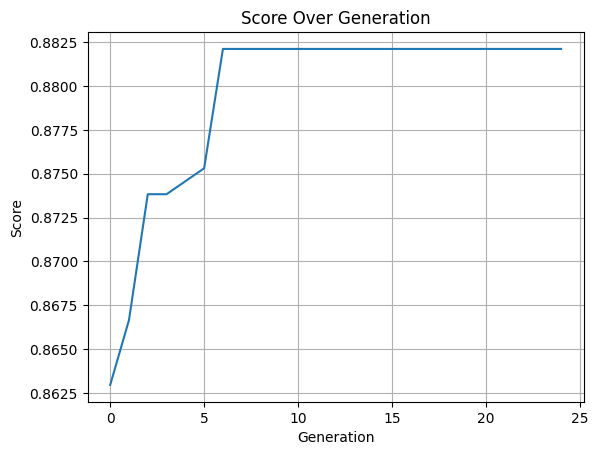

n_estimators                     240
criterion                    entropy
max_depth                         96
min_samples_split                 84
min_samples_leaf                   4
min_weight_fraction_leaf    0.100467
max_features                    sqrt
max_leaf_nodes                    26
min_impurity_decrease       0.017552
bootstrap                       True
Name: 0, dtype: object
초기해 = 450, 최대 세대수 = 25, 돌연변이율 = 0.1의 실행시간: 14180.33445930481
valid_score = 0.8821222435992305
초기해 = 450일 때 완료


Optimizing Generations: 100%|██████████| 25/25 [3:38:17<00:00, 523.91s/it]  


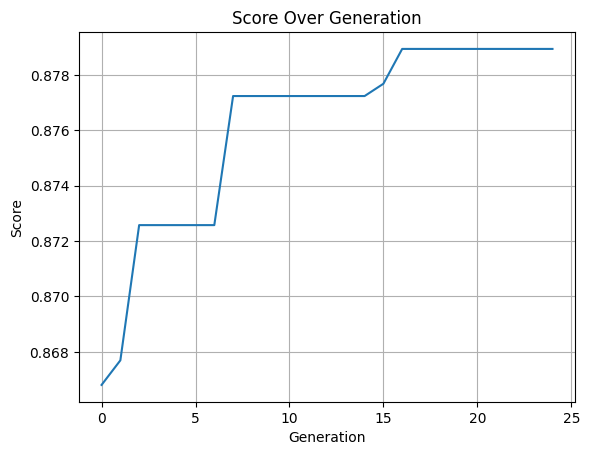

n_estimators                     473
criterion                    entropy
max_depth                         97
min_samples_split                 53
min_samples_leaf                  85
min_weight_fraction_leaf    0.117929
max_features                    None
max_leaf_nodes                     7
min_impurity_decrease       0.013746
bootstrap                       True
Name: 0, dtype: object
초기해 = 500, 최대 세대수 = 25, 돌연변이율 = 0.1의 실행시간: 13389.370757579803
valid_score = 0.8789403581471066
초기해 = 500일 때 완료


In [ ]:
from scipy.stats import uniform, randint
test_populations = [350, 400, 450, 500]
for population in test_populations:
    start_time = time.time()

    train = pd.read_csv('dataset/train.csv')

    X = train.drop(['person_id', 'login'], axis=1)
    y = train['login']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        shuffle = True, stratify = y, random_state=42)

    # params= {
    #     'n_estimators': [10, 50, 100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000],
    #     'critertion': ['gini','entropy'],
    #     'max_depth': [None, 1,5,10,15,20,25,30,35,40,45,50],
    #     'min_samples_split' : [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],
    #     'min_samples_leaf': [1, 5,10,15,20,25,30,35,40,45,50],
    #     'min_weight_fraction_leaf': [0.0, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
    #     'max_features':['sqrt','log2',None],
    #     'max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90,100],
    #     'min_impurity_decrease':[0.0, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
    #     'bootstrap': [True,False]
    # }

    params= {
        'n_estimators': randint(10, 1000),
        'critertion': ['gini','entropy'],
        'max_depth': randint(1, 100),
        'min_samples_split' : randint(2, 100),
        'min_samples_leaf': randint(1, 100),
        'min_weight_fraction_leaf': uniform(0.0, 0.5),
        'max_features':['sqrt','log2',None],
        'max_leaf_nodes':randint(2, 100),
        'min_impurity_decrease':uniform(0.0, 1.0),
        'bootstrap': [True,False]
    }


    model, hyp_param = Optimize_RFC_HP(X_train=X_train, y_train=y_train, y_test=y_test, X_test=X_test,
                                    params=params, number_of_generation=25, population_size=population,
                                    error_metric='roc_auc_score', mutation_rate=0.1, random_state = 42)
    end_time = time.time()
    tuning_time = end_time - start_time
    print(hyp_param)
    print(f'초기해 = {population}, 최대 세대수 = 25, 돌연변이율 = 0.1의 실행시간: {tuning_time}')
    
    # Series를 딕셔너리로 변환
    hyp_param_dict = hyp_param.to_dict()

    # 찾은 최적의 파라미터들을 제출 양식에 맞게 제출
    submit = pd.read_csv('dataset/sample_submission.csv')
    for param, value in hyp_param_dict.items():
        if param in submit.columns:
            submit[param] = value
            
    # score 평가
    train = pd.read_csv('dataset/train.csv')

    X = train.drop(['person_id', 'login'], axis=1)
    y = train['login']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        shuffle = True, stratify = y, random_state=42)

    model = RandomForestClassifier(random_state=42, **hyp_param_dict)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # predictions = model.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred_proba, average='macro')
    print(f'valid_score = {auc_score}')

    # submission 저장
    submit.to_csv(f'dataset/submission/submission_2({population}, 25, 0.1)_{round(auc_score,5)}.csv', index=False)
    print(f'초기해 = {population}일 때 완료')

In [ ]:
from scipy.stats import uniform, randint

start_time = time.time()

train = pd.read_csv('dataset/train.csv')

X = train.drop(['person_id', 'login'], axis=1)
y = train['login']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle = True, stratify = y, random_state=42)

# params= {
#     'n_estimators': [10, 50, 100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000],
#     'critertion': ['gini','entropy'],
#     'max_depth': [None, 1,5,10,15,20,25,30,35,40,45,50],
#     'min_samples_split' : [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],
#     'min_samples_leaf': [1, 5,10,15,20,25,30,35,40,45,50],
#     'min_weight_fraction_leaf': [0.0, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
#     'max_features':['sqrt','log2',None],
#     'max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90,100],
#     'min_impurity_decrease':[0.0, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
#     'bootstrap': [True,False]
# }

params= {
    'n_estimators': randint(10, 1000),
    'critertion': ['gini','entropy'],
    'max_depth': randint(1, 100),
    'min_samples_split' : randint(2, 100),
    'min_samples_leaf': randint(1, 100),
    'min_weight_fraction_leaf': uniform(0.0, 0.5),
    'max_features':['sqrt','log2',None],
    'max_leaf_nodes':randint(2, 100),
    'min_impurity_decrease':uniform(0.0, 1.0),
    'bootstrap': [True,False]
}


model, hyp_param = Optimize_RFC_HP(X_train=X_train, y_train=y_train, y_test=y_test, X_test=X_test,
                                 params=params, number_of_generation=100, population_size=50,
                                 error_metric='roc_auc_score', mutation_rate=0.1, random_state = 42)
end_time = time.time()
print(hyp_param)
print(end_time - start_time)

Optimizing Generations: 100%|██████████| 25/25 [44:58<00:00, 107.96s/it]


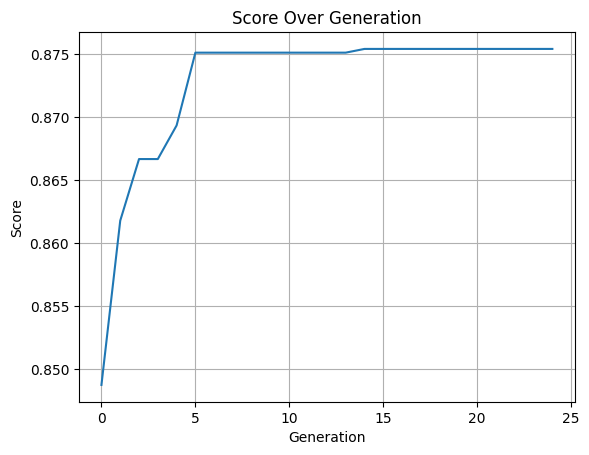

n_estimators                     980
criterion                    entropy
max_depth                         99
min_samples_split                 61
min_samples_leaf                  86
min_weight_fraction_leaf    0.086647
max_features                    None
max_leaf_nodes                    51
min_impurity_decrease       0.014545
bootstrap                       True
Name: 0, dtype: object
초기해 = 100, 최대 세대수 = 25, 돌연변이율 = 0.1의 실행시간: 2751.604737520218
valid_score = 0.8753884860145036
초기해 = 100일 때 완료


In [ ]:
from scipy.stats import uniform, randint

start_time = time.time()

train = pd.read_csv('dataset/train.csv')

X = train.drop(['person_id', 'login'], axis=1)
y = train['login']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle = True, stratify = y, random_state=42)

params= {
    'n_estimators': randint(10, 1000),
    'critertion': ['gini','entropy'],
    'max_depth': randint(1, 100),
    'min_samples_split' : randint(2, 100),
    'min_samples_leaf': randint(1, 100),
    'min_weight_fraction_leaf': uniform(0.0, 0.5),
    'max_features':['sqrt','log2',None],
    'max_leaf_nodes':randint(2, 100),
    'min_impurity_decrease':uniform(0.0, 1.0),
    'bootstrap': [True,False]
}

population = 100

model, hyp_param = Optimize_RFC_HP(X_train=X_train, y_train=y_train, y_test=y_test, X_test=X_test,
                                params=params, number_of_generation=25, population_size=population,
                                error_metric='roc_auc_score', mutation_rate=0.1, random_state = 42)
end_time = time.time()
tuning_time = end_time - start_time
print(hyp_param)
print(f'초기해 = {population}, 최대 세대수 = 25, 돌연변이율 = 0.1의 실행시간: {tuning_time}')

# Series를 딕셔너리로 변환
hyp_param_dict = hyp_param.to_dict()

# 찾은 최적의 파라미터들을 제출 양식에 맞게 제출
submit = pd.read_csv('dataset/sample_submission.csv')
for param, value in hyp_param_dict.items():
    if param in submit.columns:
        submit[param] = value
        
# score 평가
train = pd.read_csv('dataset/train.csv')

X = train.drop(['person_id', 'login'], axis=1)
y = train['login']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle = True, stratify = y, random_state=42)

model = RandomForestClassifier(random_state=42, **hyp_param_dict)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
# predictions = model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba, average='macro')
print(f'valid_score = {auc_score}')

# submission 저장
submit.to_csv(f'dataset/submission/submission({population}, 25, 0.1)_{round(auc_score,5)}.csv', index=False)
print(f'초기해 = {population}일 때 완료')